In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scipy.stats as st
import pprint
import pymc3 as pm
import theano as tt
plt.style.use('seaborn')
style = {
    'figure.figsize': (12, 8),
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 14,
}
rcParams.update(style)

# Question 1

In [113]:
data = pd.read_csv('veteran.csv', index_col=0)
data['celltype'] = data['celltype'].astype('category')

In [114]:
data.describe()

,trt,time,status,karno,diagtime,age,prior
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,1.496350,121.627737,0.934307,58.569343,8.773723,58.306569,2.919708
std,0.501821,157.816722,0.248655,20.039592,10.612141,10.541628,4.563375
min,1.000000,1.000000,0.000000,10.000000,1.000000,34.000000,0.000000
25%,1.000000,25.000000,1.000000,40.000000,3.000000,51.000000,0.000000
50%,1.000000,80.000000,1.000000,60.000000,5.000000,62.000000,0.000000
75%,2.000000,144.000000,1.000000,75.000000,11.000000,66.000000,10.000000
max,2.000000,999.000000,1.000000,99.000000,87.000000,81.000000,10.000000


Looking at the means and maxes, I will want to transform some of the variables to avoid extremely large numbers in the model.

In addition, I will be masking values with status 0 which means pymc3 will automatically treat them as missing values

In [120]:
# Masked
scaled= pd.DataFrame()
scaled['trt'] = data['trt'] - 1
scaled['celltype'] = data['celltype']
scaled['time'] = data['time'].mask(data['status']==0, np.NaN)
scaled['karno'] = data['karno'] / 100
scaled['diagtime'] = data['diagtime'] / 12
scaled['age'] = data['age'] / 100
scaled['prior'] = data['prior'] / 10
scaled.head()

,trt,celltype,time,karno,diagtime,age,prior
1,0,squamous,72.0,0.6,0.583333,0.69,0.0
2,0,squamous,411.0,0.7,0.416667,0.64,1.0
3,0,squamous,228.0,0.6,0.250000,0.38,0.0
4,0,squamous,126.0,0.6,0.750000,0.63,1.0
5,0,squamous,118.0,0.7,0.916667,0.65,1.0


$$
\beta_i \sim \text{N}(0, 10)
$$
$$
\mu = \exp(\beta_0 + \beta_1 \text{trt} + \beta_2 \text{celltype} + \beta_3 \text{karno} + \beta_4 \text{diagtime} + \beta_5 \text{age} + \beta_6 \text{prior})
$$
$$
\alpha \sim \text{Gamma}(1.1, 1.1)
$$
$$
y \sim \text{Weibull}(1/\mu, \alpha)
$$

In [121]:
with pm.Model() as model:
    beta = pm.Normal('beta', 0, sd=10, shape=7)
    logmu = beta[0] + beta[1] * scaled['trt'] + beta[2] * scaled['celltype'].cat.codes + \
              beta[3] * scaled['karno'] + beta[4] * scaled['diagtime'] + \
              beta[5] * scaled['age'] + beta[6] * scaled['prior']

    lam = pm.Deterministic('lambda', 1/pm.math.exp(logmu))
    alpha = pm.Gamma('alpha', 2, 1)
  
    y = pm.Weibull('obs', alpha, lam, observed=scaled['time'])

In [ ]:
with model:
    wtrace = pm.sample(1000, tune=1000)

I managed to get one run to work, although poorly. Almost every chain diverged, unfortunately.

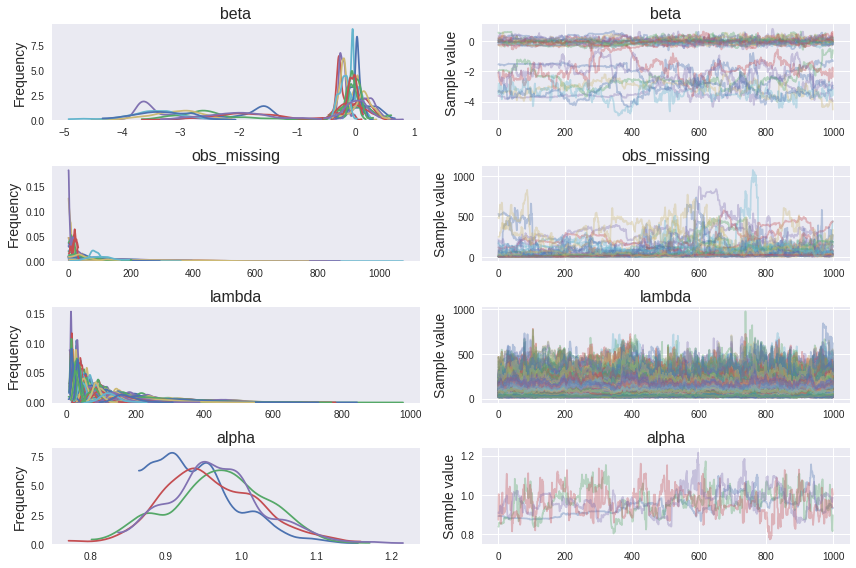

In [37]:
pm.traceplot(wtrace);

In [87]:
pm.summary(wtrace, ['beta',])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,-2.058831,0.635690,0.055768,-3.379629,-0.898812,27.0,1.126543
beta__1,0.108789,0.192766,0.013563,-0.298521,0.439228,28.0,1.046628
beta__2,-0.223809,0.077757,0.005420,-0.378583,-0.075846,57.0,1.026744
beta__3,-3.331906,0.453383,0.037525,-4.128229,-2.388134,35.0,1.068426
beta__4,-0.010943,0.107281,0.008255,-0.211534,0.195045,48.0,1.006806
beta__5,-0.042556,0.084851,0.007148,-0.204314,0.123330,37.0,1.097669
beta__6,0.025645,0.241656,0.019639,-0.399096,0.521171,38.0,1.055021


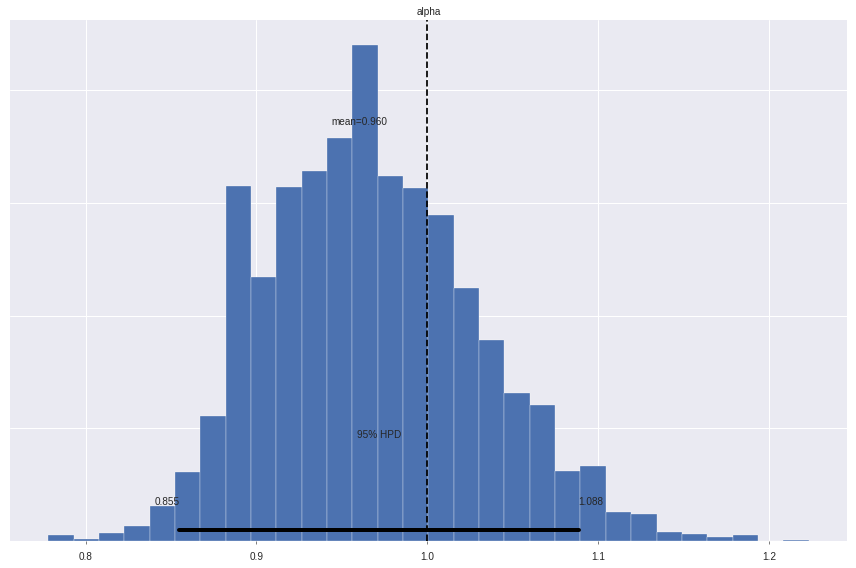

In [89]:
pm.plot_posterior(wtrace, ['alpha',])
plt.axvline(1, c='k', ls='--');

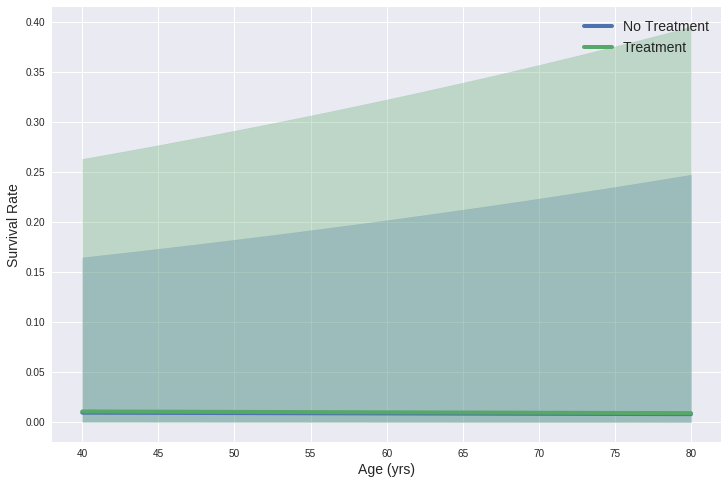

In [91]:
ages = np.linspace(40, 80)
betas = np.percentile(wtrace['beta'], [2.5, 50, 97.5], axis=0)

def y_preds(betas, treatment, scaled_ages):
    y_preds = [np.exp(beta[0] + beta[1] * treatment + beta[2] * 2 + beta[3] * .6 + beta[4] * 5/12  + beta[5] * scaled_ages) for beta in betas]

    return y_preds

y_0 = y_preds(betas, 0, ages/10)
y_1 = y_preds(betas, 1, ages/10)
plt.plot(ages, y_0[1], lw=4, label='No Treatment')
plt.fill_between(ages, y_0[0], y_0[2], alpha = .3, color='C0')
plt.plot(ages, y_1[1], lw=4, label='Treatment')
plt.fill_between(ages, y_1[0], y_1[2], alpha = .3, color='C1')
plt.xlabel('Age (yrs)')
plt.ylabel('Survival Rate')
plt.legend();

Given that my modeling isn't quite correct, that may explain why these bounds are weird as heck. I can tell you that the median lines do decrease over time but I have no clue why the upper limits are increasing. For instance, I will show you what the plots look like from percentiles 40-60

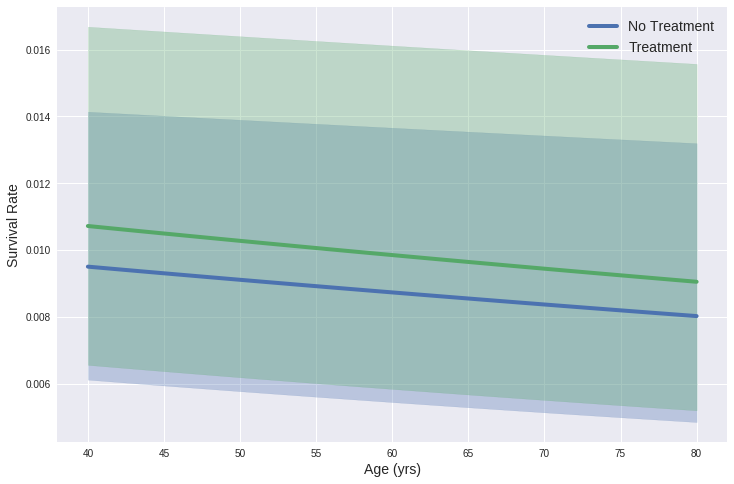

In [92]:
betas = np.percentile(wtrace['beta'], [40, 50, 60], axis=0)
y_0 = y_preds(betas, 0, ages/10)
y_1 = y_preds(betas, 1, ages/10)
plt.plot(ages, y_0[1], lw=4, label='No Treatment')
plt.fill_between(ages, y_0[0], y_0[2], alpha = .3, color='C0')
plt.plot(ages, y_1[1], lw=4, label='Treatment')
plt.fill_between(ages, y_1[0], y_1[2], alpha = .3, color='C1')
plt.xlabel('Age (yrs)')
plt.ylabel('Survival Rate')
plt.legend();

#### 1.f

Again, I will use smaller percentiles because of issues with whatever is going wrong

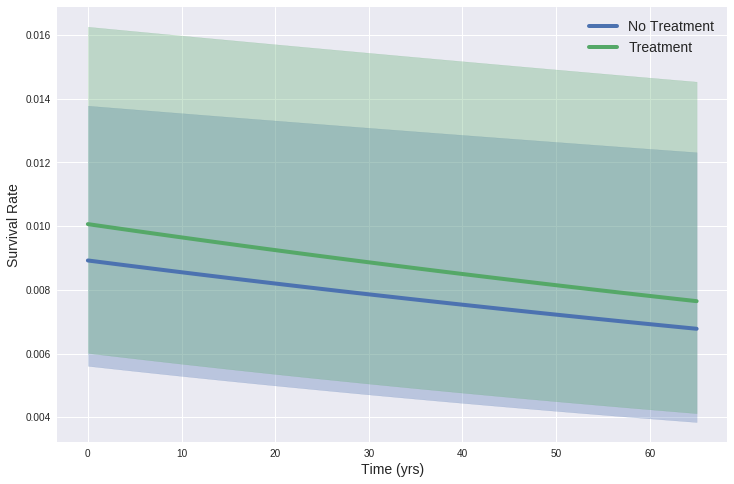

In [94]:
ages = np.linspace(55, 120)
betas = np.percentile(wtrace['beta'], [40, 50, 60], axis=0)
y_0 = y_preds(betas, 0, ages/10)
y_1 = y_preds(betas, 1, ages/10)
plt.plot(ages - 55, y_0[1], lw=4, label='No Treatment')
plt.fill_between(ages - 55, y_0[0], y_0[2], alpha = .3, color='C0')
plt.plot(ages - 55, y_1[1], lw=4, label='Treatment')
plt.fill_between(ages - 55, y_1[0], y_1[2], alpha = .3, color='C1')
plt.xlabel('Time (yrs)')
plt.ylabel('Survival Rate')
plt.legend();

# Question 2

In [3]:
data = pd.read_table('JawBoneData.txt', sep=',\s', names=['8', '8.5', '9', '9.5'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


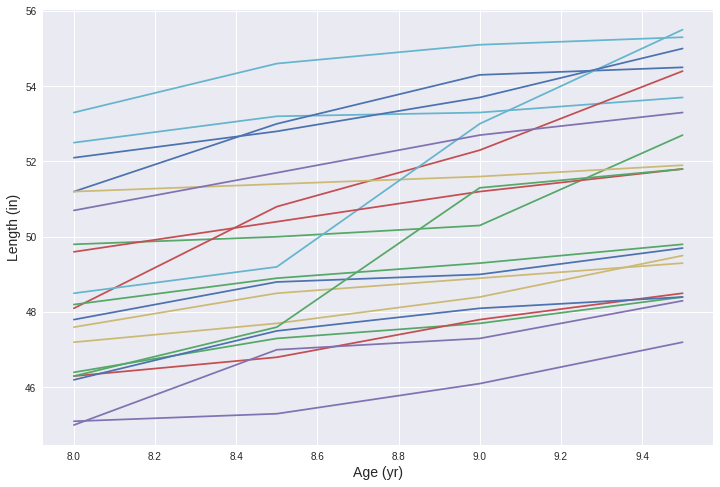

In [4]:
ages = np.array([8, 8.5, 9, 9.5])
plt.plot(data.T)
plt.xlabel('Age (yr)')
plt.ylabel('Length (in)');

#### 2.a
For the variances I use half-cauchy distribution because of Gelman recommendation; it is limited to (0,$\infty$) and has only one parameter for scale.

In [5]:
with pm.Model() as model_1:
    b0 = pm.Normal('b0', 0, 100)
    b1 = pm.Normal('b1', 0, 100)
    sb = pm.HalfCauchy('sb', 100)
    sw = pm.HalfCauchy('sw', 100)
    
    z = pm.Normal('z', 0, sb, shape=(20,1))
    
    mu = b0 + b1 * ages + z
    sd = sw
    like = pm.Normal('y', mu=mu, sd=sd, observed=data)

In [6]:
with model_1:
    trace_1 = pm.sample(5000, tune=1000, nuts_kwargs={'target_accept':.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sw_log__, sb_log__, b1, b0]
  1%|          | 71/6000 [00:06<08:39, 11.42it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '6201' (I am process '6202')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jovyan/.theano/compiledir_Linux-4.9-linuxkit-aufs-x86_64-with-debian-stretch-sid-x86_64-3.6.3-64/lock_dir
 98%|█████████▊| 5883/6000 [02:18<00:02, 42.41it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '7986' (I am process '5961')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jovyan/.theano/

In [7]:
pprint.pprint(pm.effective_n(trace_1))

{'b0': 5054.0,
 'b1': 9327.0,
 'sb': 8959.0,
 'sw': 10013.0,
 'z': array([[1871.],
       [1918.],
       [1903.],
       [1888.],
       [1901.],
       [1825.],
       [1877.],
       [1861.],
       [1885.],
       [1900.],
       [1896.],
       [1853.],
       [1895.],
       [1834.],
       [1884.],
       [1859.],
       [1859.],
       [1854.],
       [1883.],
       [1868.]])}


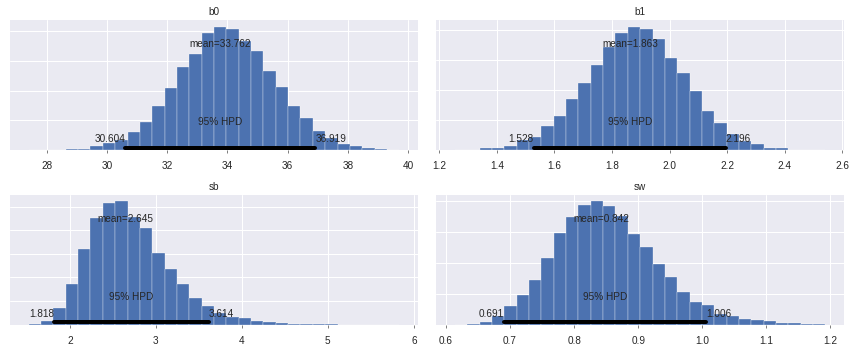

In [8]:
pm.plot_posterior(trace_1, ['b0', 'b1', 'sb', 'sw']);

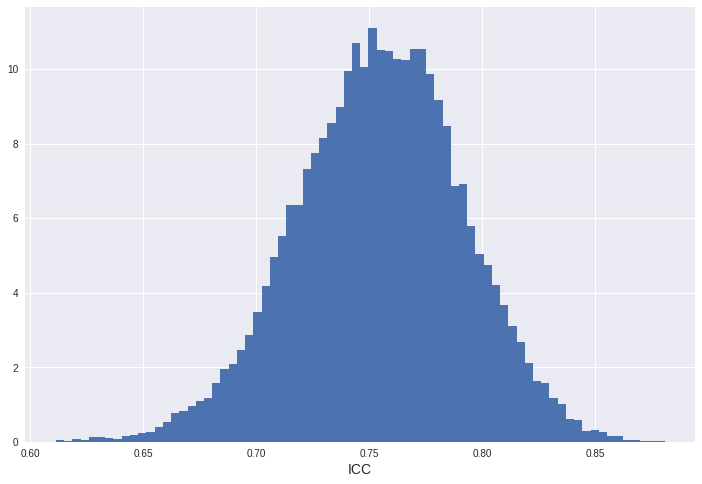

In [9]:
icc = trace_1['sb'] / (trace_1['sb'] + trace_1['sw'])
plt.hist(icc, bins='auto', normed=True)
plt.xlabel('ICC');

The above shows that the variance between kids accounts for about 75% of the variance, which implies that around 25% of the variances is from within kid measurements. So measurements on the same child should be generally more consistent.

100%|██████████| 10000/10000 [00:07<00:00, 1268.67it/s]


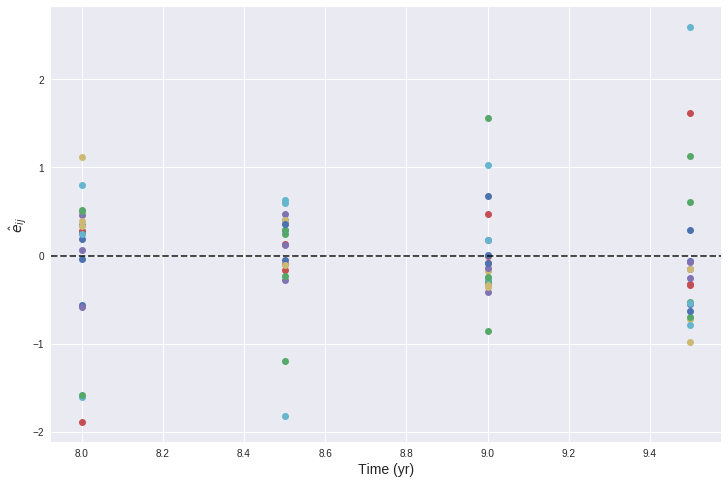

In [10]:
ppc = pm.sample_ppc(trace_1, samples=10000, model=model_1)
y_pred = ppc['y'].T.mean(axis=2)
wc_res = data.T - y_pred
plt.plot(wc_res, 'o')
plt.axhline(0, ls='--', c='k', alpha=.8)
plt.xlabel('Time (yr)')
plt.ylabel(r'$\hat{e}_{ij}$')

The above residuals show that there is a large grouping of kids near 0 with a few outliers on each spot. In general, the model is overestimating the first year and underestimating the second year

### 2.e
Again, I will use Half Cauchy for the conjugate prior of each variance for the normal distributions. 

In [11]:
with pm.Model() as model_2:
    b0 = pm.Normal('b0', 0, 100)
    s0 = pm.HalfCauchy('s0', 100)
    b1 = pm.Normal('b1', 0, 100)
    s1 = pm.HalfCauchy('s1', 100)
    
    b0i = pm.Normal('b0i', b0, s1, shape=(20,1))
    b1i = pm.Normal('b1i', b1, s1, shape=(20,1))
    
    sw = pm.HalfCauchy('sw', 100)
    
    mu = b0i + b1i * ages
    sd = sw
    like = pm.Normal('y', mu=mu, sd=sd, observed=data)

In [14]:
with model_2:
    trace_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sw_log__, b1i, b0i, s1_log__, b1, s0_log__, b0]
100%|██████████| 2000/2000 [00:56<00:00, 35.26it/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8983785964317228, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
pprint.pprint(pm.effective_n(trace_2))

{'b0': 176.0,
 'b0i': array([[174.],
       [183.],
       [182.],
       [181.],
       [185.],
       [185.],
       [170.],
       [182.],
       [184.],
       [184.],
       [181.],
       [185.],
       [170.],
       [185.],
       [170.],
       [182.],
       [184.],
       [184.],
       [187.],
       [182.]]),
 'b1': 183.0,
 'b1i': array([[199.],
       [196.],
       [196.],
       [195.],
       [203.],
       [181.],
       [179.],
       [197.],
       [195.],
       [199.],
       [196.],
       [200.],
       [183.],
       [200.],
       [202.],
       [196.],
       [198.],
       [199.],
       [202.],
       [199.]]),
 's0': 731.0,
 's1': 1095.0,
 'sw': 1375.0}


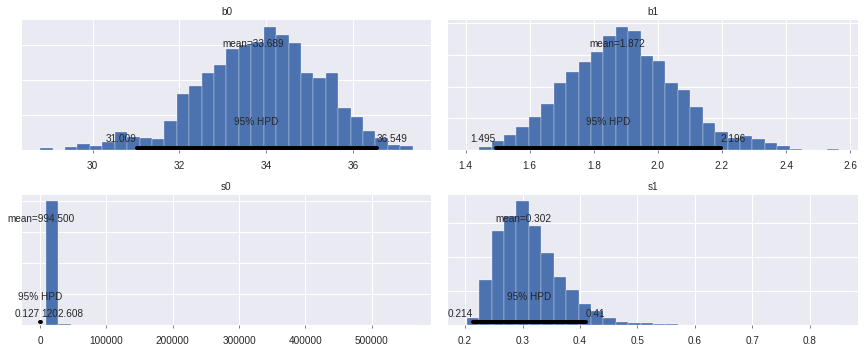

In [16]:
pm.plot_posterior(trace_2, ['b0', 'b1', 's0', 's1']);

In [17]:
growth_rate = trace_2['b1i'].mean(axis=0)
fastest = np.argmax(growth_rate)
print('Fastest growth rate is child {} with rate {} in/yr'.format(fastest, 2*growth_rate[fastest]))

Fastest growth rate is child 17 with rate [4.71996174] in/yr


#### 2.g
I will create a distribution of the samples of growth rate ($\beta_1$) for the first and second child and see if the  value 0 falls within the 95% credible set.

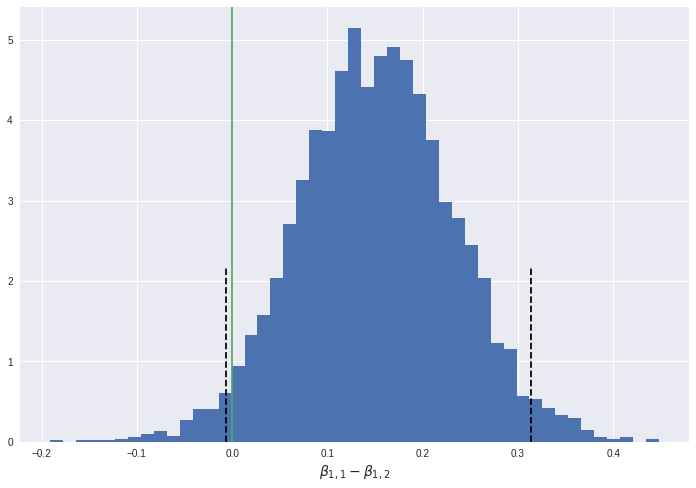

In [18]:
diff = trace_2['b1i'][:, 0, 0] - trace_2['b1i'][:, 1, 0]
plt.hist(diff, bins='auto', normed=True)
p1,p2 = np.percentile(diff, [2.5, 97.5])
plt.axvline(p1, ymax=.4, color='k', ls='--')
plt.axvline(p2, ymax=.4, color='k', ls='--')
plt.axvline(0, ymax=1, color='C1', ls='-')
plt.xlabel(r'$\beta_{1,1} - \beta_{1, 2}$')

There is *technically* no significant difference in growth rates but it is very close. Personally I would lean towards saying there is a difference in growth rates

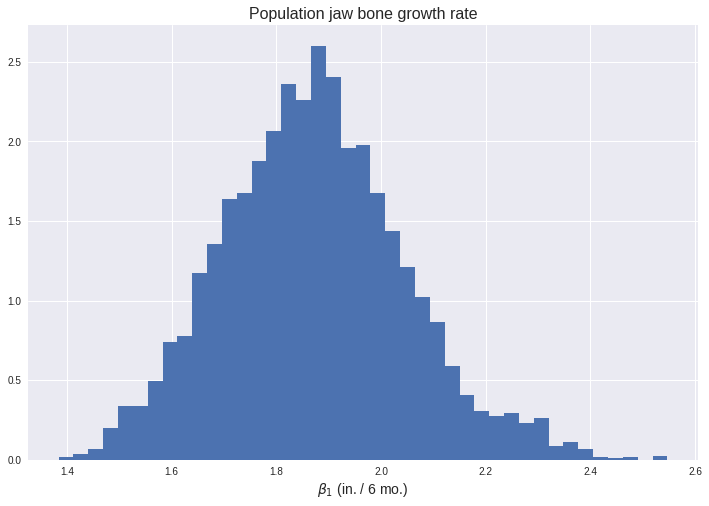

In [19]:
plt.title('Population jaw bone growth rate')
plt.hist(trace_2['b1'], normed=True, bins='auto')
plt.xlabel(r'$\beta_1$ (in. / 6 mo.)');

#### 2.j Differences

The first model can be interpreted as that there is some static difference between each kid but that the starting size and growth rates are equal for every child. The static difference could be considered the difference from the standard starting length.

The second model assumes that each kid has a unique starting length AND growth rate, but that these values can be parameterized in general for a whole population. 

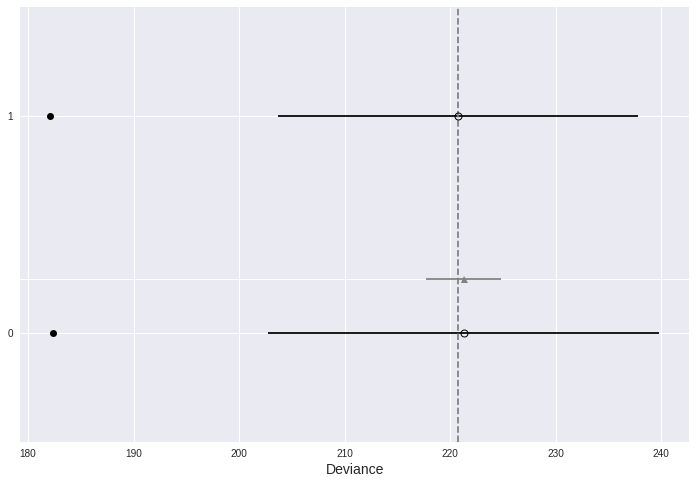

In [22]:
pm.compareplot(pm.compare([trace_1, trace_2], [model_1, model_2]))

# Question 3

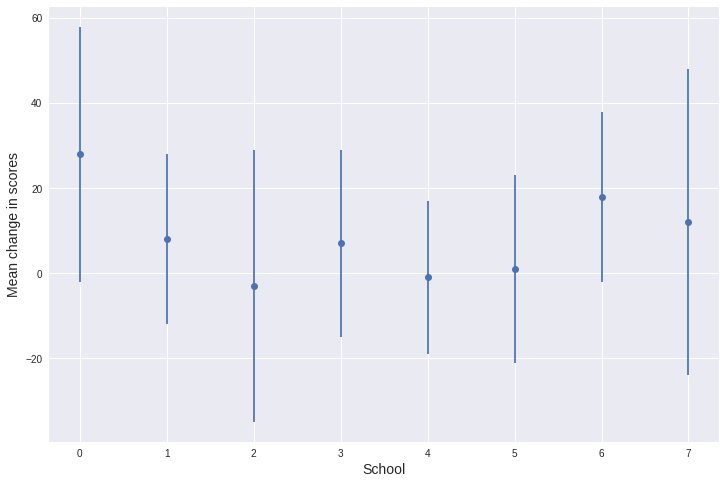

In [22]:
schoolobs = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])
plt.errorbar(range(len(schoolobs)), schoolobs, yerr=2*sigma, fmt='o')
plt.xlabel('School')
plt.ylabel('Mean change in scores');

### Model
I will be taking ideas from this [page](https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html) for help on implementation

For this model, I will parameterize the observations with a non-centered but scaled normal distribution of which the mean and variance have hyper-parameteric distributions like so:
$$ \mu \sim N(0,5) $$
$$ \tau \sim \text{Half-Cauchy}(0,5) $$
$$ \tilde{\theta_n} \sim N(0,1)$$
$$ \theta_n = \mu + \tau\cdot\tilde{\theta_n}$$
$$ y_n \sim N(\theta_n, \sigma_n) $$
Where $\sigma_n$ is from the data

I chose to use this non-centered because it helps minimize thet number of divergences in the chains. I am not fully positive of the logic, but the article I linked above showed how it changes the effectiveness of the NUTS sampler for hierarchical models.

In [23]:
with pm.Model() as hierarchical_model:
    mu = pm.Normal('mu', 0, 5)
    tau = pm.HalfCauchy('tau', 5)
    theta_raw = pm.Normal('theta_r', 0, 1, shape=len(schoolobs))
    theta = pm.Deterministic('theta', mu + tau * theta_raw)
    like = pm.Normal('obs', theta, sigma, observed=schoolobs)
    
    htrace = pm.sample(5000, tune=2000, nuts_kwargs={'target_accept':.85})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_r, tau_log__, mu]
100%|██████████| 7000/7000 [00:08<00:00, 803.98it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


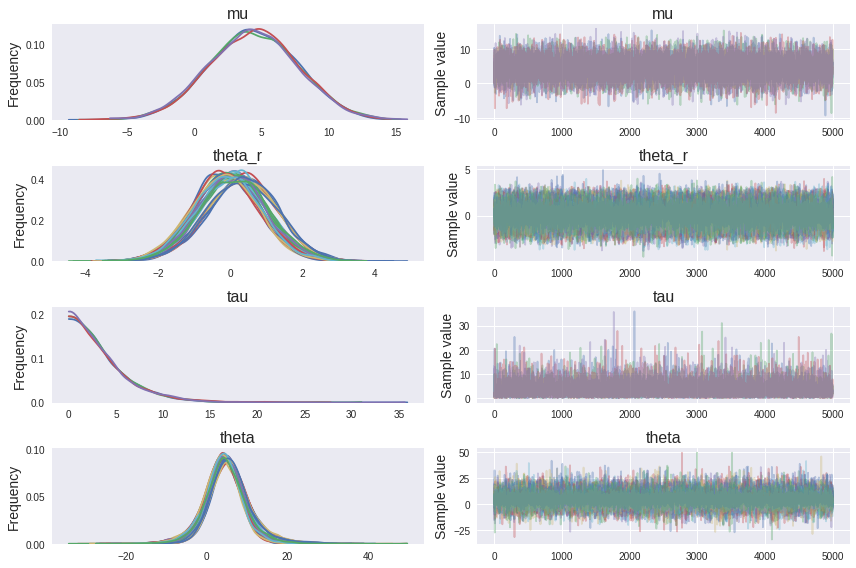

In [24]:
pm.traceplot(htrace);

In [25]:
obs = pm.sample_ppc(htrace, 10000, hierarchical_model)['obs'].T

100%|██████████| 10000/10000 [00:02<00:00, 3688.61it/s]


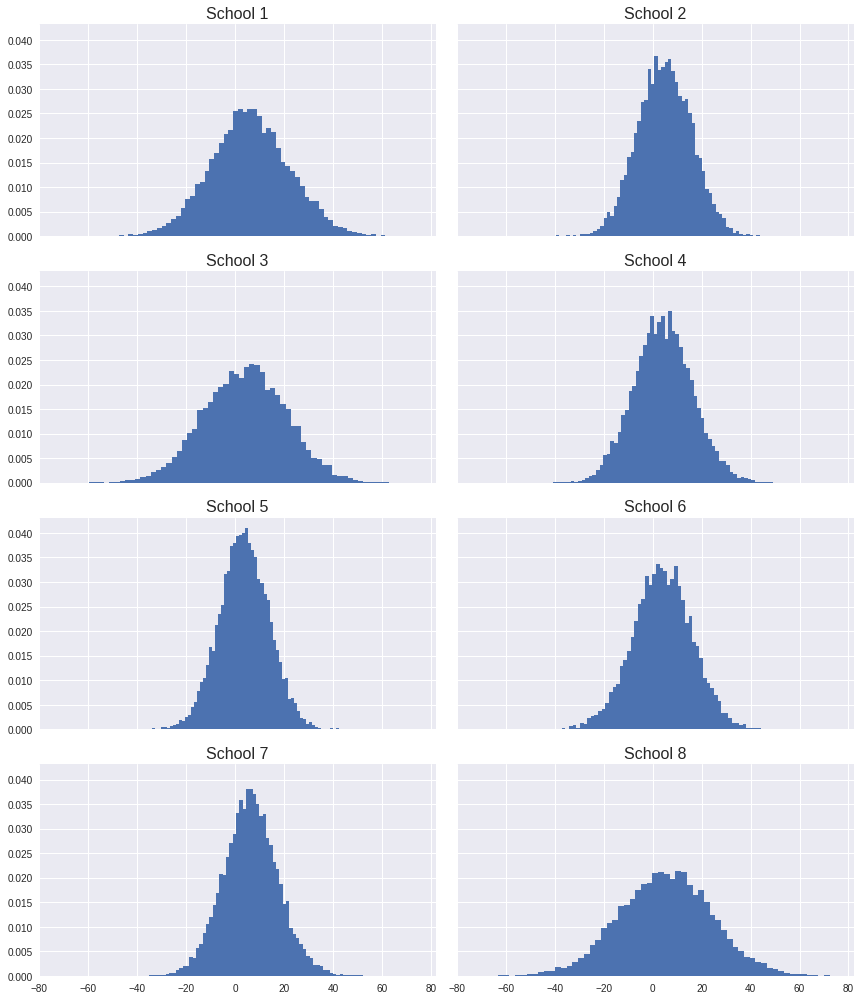

In [26]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(12, 14))
for i, data in enumerate(obs):
    ax = axes[int(i / 2), i % 2]
    ax.hist(data, normed=True, bins='auto')
    ax.set_title('School {}'.format(i+1))
    
plt.tight_layout()

From this analysis, if we consider the variance of the effects, there isn't a significant difference in the schools programs, and overall the difference isnt' overwhelmingly large. Most means occer close to 0 with such high variance, albeit generally higher than 0.